In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

# Loading maps

In [2]:
import mapping.utils as maps
import matplotlib.pyplot as plt

In [3]:
FILE = './data/file150.json' # Sample file

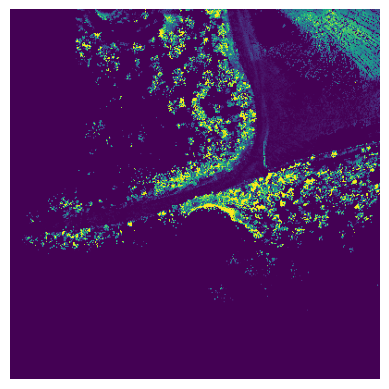

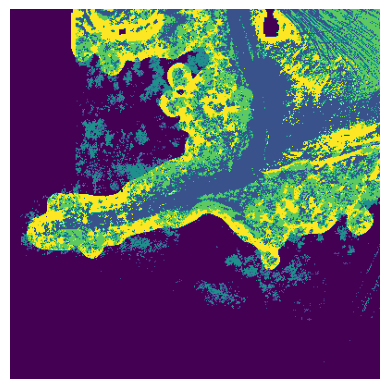

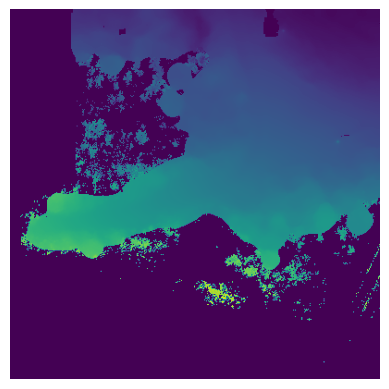

In [4]:
object_map, observed_map, terrain_map, origin_x, origin_y, resolution, num_x, num_y = maps.load_layers(FILE)

plt.imshow(object_map, origin ='lower')
plt.axis('off')
plt.savefig("assets/object_map-150.png", bbox_inches='tight')
plt.show()

plt.imshow(observed_map, origin ='lower')
plt.axis('off')
plt.savefig("assets/observed_map-150.png", bbox_inches='tight')
plt.show()

plt.imshow(terrain_map, origin ='lower')
plt.axis('off')
plt.savefig("assets/terrain_map-150.png", bbox_inches='tight')
plt.show()

## Finding a path with a Rapidly-exploring Random Tree (RRT)

In [5]:
import sys
from pathlib import Path

PATH_TO_SHARED_LIB = str(Path("").resolve()) + "/rrt_sharp/src/rrt_sharp/build/"
sys.path.append(PATH_TO_SHARED_LIB)

from rrt_sharp_py import *

In [6]:
version = 7

In [36]:
# Configure RRTSharp object

# Create Map dimension
rrt_sharp = RRTSharp([2, 3, 4])

rrt_sharp.set_map_info(origin_x, origin_y, resolution, num_x, num_y)
rrt_sharp.set_object_map(object_map.flatten().tolist())
rrt_sharp.set_observed_map(observed_map.astype(int).flatten().tolist())
rrt_sharp.set_terrain_map(terrain_map.flatten().tolist())
rrt_sharp.set_start_state(227.0, -143.0, 180.0)
rrt_sharp.set_goal_state(114.0, -250.0, 300.0)
rrt_sharp.set_stop_radius(5.0)

# Run RRT

rrt_sharp.init()
rrt_sharp.run()

Reached
Reached
numNodes: 2774, numChildren: 2774
total: 385.343 ms


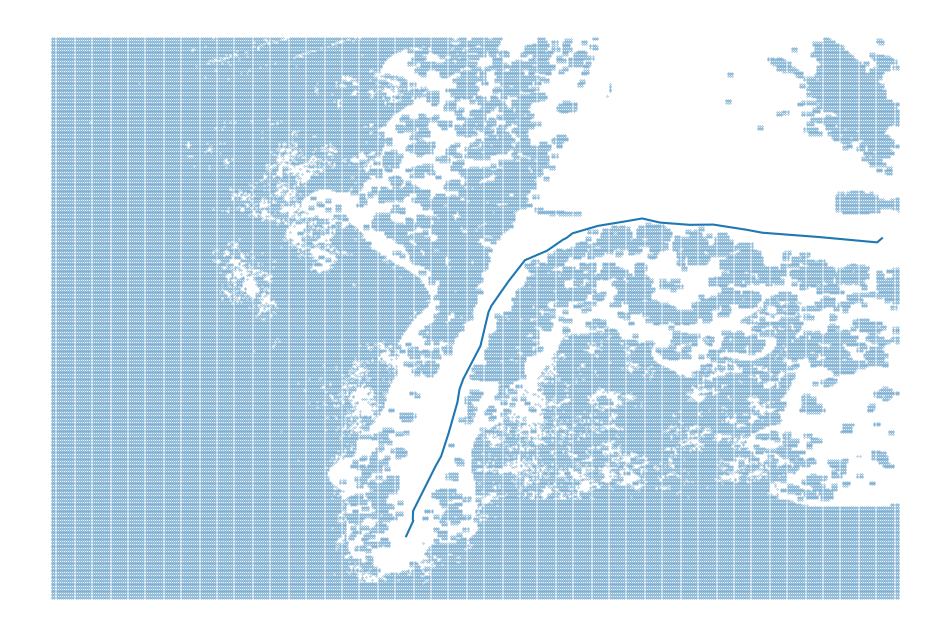

In [37]:
traj_x = np.array(list(rrt_sharp.get_trajectory_x()))
traj_y = np.array(list(rrt_sharp.get_trajectory_y()))

search_space_x = list(rrt_sharp.get_search_space_x())
search_space_y = list(rrt_sharp.get_search_space_y())

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(traj_x, traj_y)

plt.axis('off')
#plt.savefig(f"assets/iLQR/rrt-150-{version}.png", bbox_inches='tight')
plt.show()

# Simulating dynamics

In [38]:
import optimization.bicycle_model as bicycle_model
from optimization.utils import *
import optimization.quadratic as qr

## Simple example

In [39]:
model = bicycle_model.BicycleModelParameters(dt=0.02, max_steering_angle=3, min_steering_angle=-3, wheelbase=1)

# state: x, y, yaw, velocity

nx = 4
x0 = np.array([0, 0, 0, 0.2]) # initial state

# controls: acceleration, steering_angle

nu = 2
U = np.array([[2, 0], [1.2, 0.3], [1.4, 0.4], [0, 0.2]])

N = U.shape[0]+1

# Simulate dynamics

params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

# Caution: no constraints on the controls are handled by the forward pass/dynamics
X = simulate(x0, U, bicycle_model.discrete_dynamics, params)

print(X)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-01]
 [4.40000000e-03 0.00000000e+00 0.00000000e+00 2.40000000e-01]
 [9.43999861e-03 3.74173093e-06 1.55905470e-03 2.64000000e-01]
 [1.49999787e-02 1.86159853e-05 3.90978499e-03 2.92000000e-01]
 [2.08399195e-02 4.49058146e-05 5.09361160e-03 2.92000000e-01]]


## Using iLQR to follow reference trajectory

Now, we need to convert `traj_x` and `traj_y` from RRT to corresponding `Xref` and `Uref` with correct sizes

In [40]:
N = max(traj_x.shape[0], traj_x.shape[0] * (250//traj_x.shape[0]))

# Upsample trajectories if necessary
if N > traj_x.shape[0]:
    upsampling_factor = 250//traj_x.shape[0]
    
    # Forming points
    points = np.dstack((traj_x, traj_y)).squeeze()
    
    # Forming groups of consecutive points
    n_groups = len(traj_x) - 1
    indices = np.arange(n_groups)[:, None] + np.array([0, 1])
    groups = points[indices]
    
    # We upsample by doing linear interpolation between points
    new_groups = np.linspace(groups[:, 0], groups[:, 1], 1+upsampling_factor, axis=1)
    
    # We merge the new points
    new_groups = new_groups[:, :-1, :] # skipping last point of each group to avoid duplicates
    new_points = np.vstack((new_groups.reshape((-1, 2)), points[None, -1, :])) # don't forget very last point
    
    traj_x = new_points[:, 0]
    traj_y = new_points[:, 1]
    
    N = traj_x.shape[0]
    
# create reference trajectory 
Xref, Uref = np.array([traj_x, traj_y, np.zeros(N), 30*np.ones(N)]).T, np.zeros((N-1, nu))

angles = []

# Guess yaw angles
for k in range(len(Xref) - 1):
    p1 = Xref[k]
    p2 = Xref[k+1]
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0]) # tan^-1(Δy/Δx)
    angle = angle if angle > 0 else angle + 2*np.pi
    angles.append(angle)
angles.append(angles[-1])
    
last_angle = angles[0]
for k in range(len(Xref)):
    angle = angles[k]
    Xref[k, 2] = (last_angle + angle)/2 # average of yaw angles
    last_angle = angle

for k in range(len(Xref) - 1):
    # estimating the steering angle very roughly
    diff_angles = Xref[k+1, 2] - Xref[k, 2]
    Uref[k, 1] = diff_angles*1.4
#Uref[-80:, 0] = 160
#Uref[-50:, 0] = -140

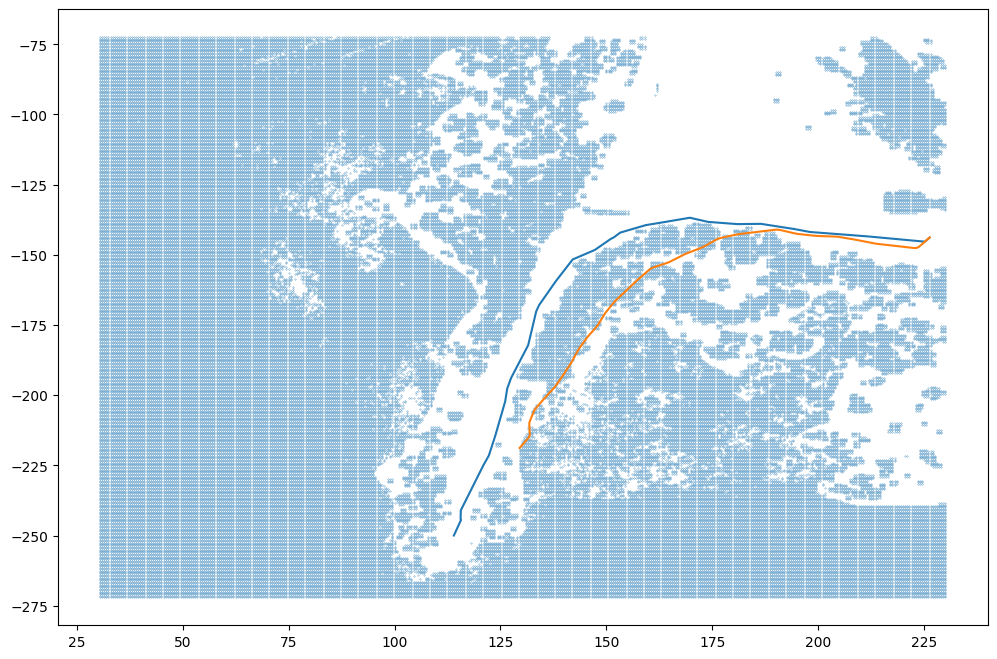

In [41]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

params.N = Uref.shape[0]+1
X = simulate(Xref[0], Uref, bicycle_model.discrete_dynamics, params)

Xref[:, 3] = X[:, 3] # update velocities with more accurate ones

plt.plot(Xref[:, 0], Xref[:, 1])
plt.plot(X[:, 0], X[:, 1])
#plt.savefig(f"assets/iLQR/guess-150-{version}.png", bbox_inches='tight')
plt.show()

Xref length: 241
Uref length: 240
 
Optimizing chunk 0
X: 0-29
U: 0-28
iLQR converged in 616 iteration(s)
 
Optimizing chunk 1
X: 29-59
U: 29-58
iLQR converged in 456 iteration(s)
 
Optimizing chunk 2
X: 59-89
U: 59-88
iLQR converged in 40 iteration(s)
 
Optimizing chunk 3
X: 89-119
U: 89-118
iLQR converged in 88 iteration(s)
 
Optimizing chunk 4
X: 119-149
U: 119-148
iLQR converged in 117 iteration(s)
 
Optimizing chunk 5
X: 149-179
U: 149-178
iLQR converged in 420 iteration(s)
 
Optimizing chunk 6
X: 179-209
U: 179-208
iLQR converged in 410 iteration(s)
 
Optimizing chunk 7
X: 209-239
U: 209-238
iLQR converged in 385 iteration(s)
 
Optimizing chunk 8
X: 239-269
U: 239-268
iLQR converged in 3 iteration(s)
Optimization done


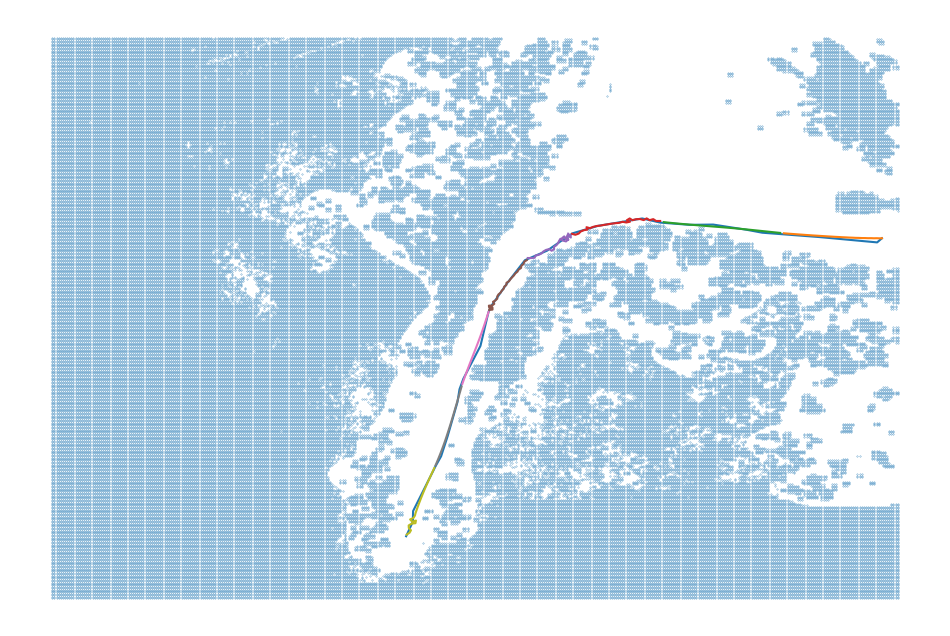

In [42]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ion() # enable interactivity

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(Xref[:, 0], Xref[:, 1])

plt.axis('off')
#plt.savefig(f"assets/iLQR/iLQR-150-{version}.png", bbox_inches='tight')
#plt.show()

# problem size 
dt = model.dt

# tracking cost function
Q = np.diag([4, 4, 0.5, 0.1])
R = np.diag([0.1, 0.2])
Qf = 10*Q

arrX = []
arrU = []
arrK = []

print(f"Xref length: {len(Xref)}")
print(f"Uref length: {len(Uref)}")

chunk = 30
i = 0
while (i*chunk) < len(Xref):
    print(" ")
    print(f"Optimizing chunk {i}")
    
    print(f"X: {chunk*i if i==0 else chunk*i-1}-{chunk*(i+1)-1}")
    print(f"U: {chunk*i if i==0 else chunk*i-1}-{chunk*(i+1)-1-1}")
    
    subX = Xref[chunk*i:chunk*(i+1)]
    subU = Uref[chunk*i if i==0 else chunk*i-1:chunk*(i+1)-1]
    
    if i > 0:
        x0 = np.array([arrX[-1][-1]])
        subX = np.vstack((x0, subX)) # append last of previous chunk

    # the params needed by iLQR 
    qrParams = qr.QR(
        Q=Q,
        Qf=Qf,
        R=R,
        Xref=subX,
        Uref=subU,
        nx=params.nx,
        nu=params.nu,
        N=len(subX),
        model=params.model
    )

    # initial condition 
    x0 = subX[0]

    # initial guess controls 
    U = subU
    U[:, 0] += 1e-10*np.random.normal(size=subU.shape[0]) # for controllability

    # solve with iLQR
    Xi, Ui, Ki = qr.iLQR(x0, U, bicycle_model.discrete_dynamics, bicycle_model.discrete_dynamics_grad, qrParams)
    
    if i > 0:
        Xi = Xi[1:] # remove first element to avoid duplicates
    
    arrX.append(Xi)
    arrU.append(Ui)
    arrK.append(Ki)
    
    plt.plot(Xi[:, 0], Xi[:, 1])
    
    i += 1
    
print("Optimization done")

In [43]:
X = np.array([ptx for subarr in arrX for ptx in subarr])
U = np.array([ptu for subarr in arrU for ptu in subarr])
K = np.array([ptk for subarr in arrK for ptk in subarr])

In [44]:
print(X.shape)
print(U.shape)

(241, 4)
(240, 2)


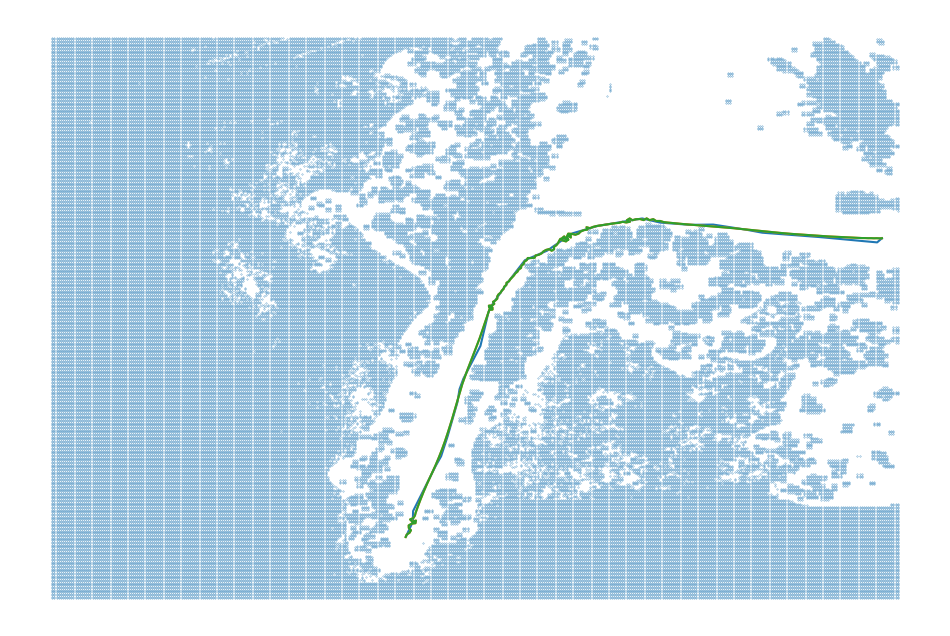

In [45]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(Xref[:, 0], Xref[:, 1])
plt.plot(X[:, 0], X[:, 1])

params.N = len(X)
Xsim = simulate(X[0], U, bicycle_model.discrete_dynamics, params)
plt.plot(Xsim[:, 0], Xsim[:, 1])

plt.axis('off')
#plt.savefig(f"assets/iLQR/iLQR-150-{version}.png", bbox_inches='tight')
plt.show()

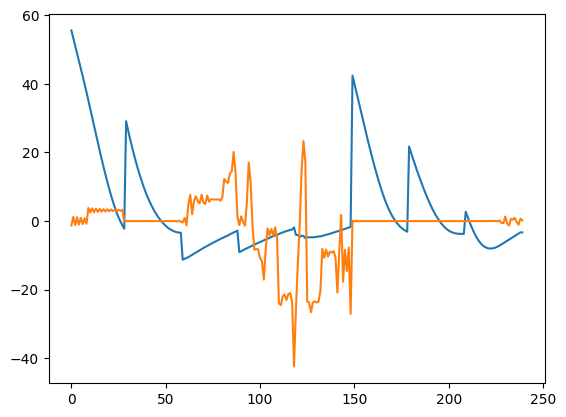

In [46]:
plt.plot(U)